In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from transformers import ViTImageProcessor, ViTForImageClassification

In [1]:
src_dir = './train_img'

classes = {
    img_class: idx for idx, img_class in enumerate(os.listdir(src_dir))
}
classes

{'Long': 0, 'Vinh': 1}

In [2]:
path_images = []
for img_class in os.listdir(src_dir):
    class_dir = os.path.join(src_dir, img_class) # train_img/vinh or train_img/long
    for img in os.listdir(class_dir):
        path_image = os.path.join(class_dir, img)
        path_images.append(path_image)
path_images[:5]

['./train_img/Long/cropped_face_44.jpg',
 './train_img/Long/cropped_face_22.jpg',
 './train_img/Long/cropped_face_9.jpg',
 './train_img/Long/cropped_face_36.jpg',
 './train_img/Long/cropped_face_10.jpg']

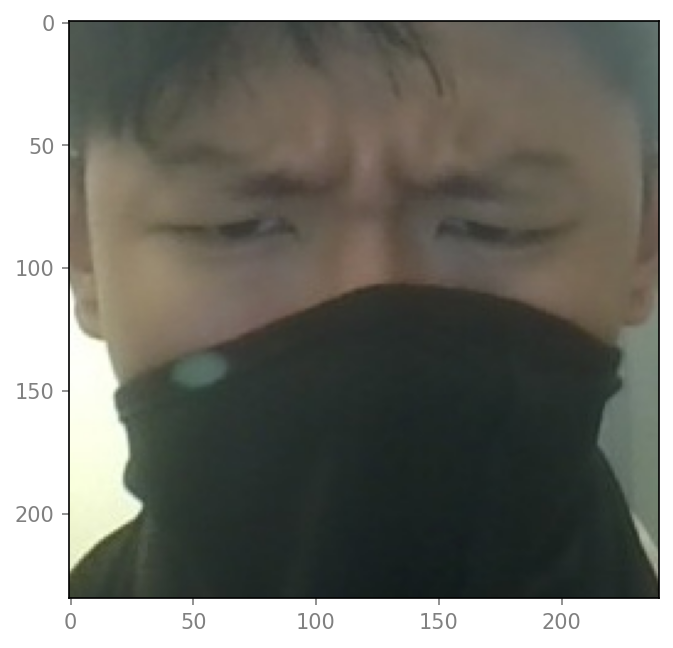

In [3]:
# train_dataset
data = {
    'images': [],
    'labels': []
}

for path_image in path_images:
    img = cv2.imread(path_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    data['images'].append(img)
    data['labels'].append(classes[path_image.split('/')[-2]]) # train_img/vinh/*.jpg, -2 is vinh

plt.imshow(data['images'][0])

In [4]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(
    data['images'],
    data['labels'],
    test_size=0.2,
    random_state=42
)
len(train_images), len(test_images), len(train_labels), len(test_labels)

(90, 23, 90, 23)

In [ ]:
# Define Metric
def cosine_similarity(query_vector, src_vectors):
    dot_product = np.dot(
        src_vectors,
        query_vector
    )
    src_norm = np.linalg.norm(src_vectors, axis = 1)
    query_norm = np.linalg.norm(query_vector)
    cosine_similarity = dot_product / (src_norm * query_norm)
    return cosine_similarity

In [ ]:
# Define ranking function
def ranking(
    preprocessed_query_image,
    preprocessed_src_images,
    top_k = 10
):
    scores = cosine_similarity(
        preprocessed_query_image,
        preprocessed_src_images
    )

    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]
    return ranked_list, scores

In [ ]:
#Define preprocessing  function
def preprocessing(images):
    if isinstance(images, list):
        inputs = processor(images, return_tensors='pt').to(device)
    else:
        inputs = processor(images, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True).hidden_states[-1][:, 0, :].detach().cpu().numpy()
    return outputs

In [ ]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k=10):
    scores = cosine_similarity(preprocessed_query_image, preprocessed_src_images)
    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]
    return ranked_list, scores
     

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device)

In [5]:
# Preprocess train_images and test_images
train_images_preprocessed = preprocessing(train_images)

train_images_preprocessed.shape

(90, 768)

In [6]:
# Preprocess test_images
test_images_preprocessed = preprocessing(test_images)
test_images_preprocessed.shape

(23, 768)

In [7]:
# accuracy
top_k = 5
test_image_preprocessed = test_images_preprocessed[0]
test_label = test_labels[0]

ranked_list, scores = ranking(test_image, train_images_preprocessed, top_k=top_k)

print('Query Image')
query_image = test_images[0]

plt.figure(figsize=(3, 3))
plt.imshow(query_image)
plt.axis('off')
plt.show()

print(f'Top {top_k} similar images')
for idx in range(len(ranked_list)):

    src_image_idx = ranked_list[idx]
    similarity_score = scores[idx]
    plt.figure(figsize=(3, 3))
    plt.imshow(train_images[src_image_idx])
    plt.title(f'Similarity: {similarity_score:.10f}')
    plt.axis('off')
    plt.show()

--------------------------------------------------------------------------
NameError                                Traceback (most recent call last)
Cell In[13], line 6
      3 test_image_preprocessed = test_images_preprocessed[0]
      4 test_label = test_labels[0]
----> 6 ranked_list, scores = ranking(test_image, train_images_preprocessed, top_k=top_k)
      8 print('Query Image')
      9 query_image = test_images[0]

NameError: name 'test_image' is not defined


In [8]:
# Luu file npoy
# THem Labels cho train_images_preprocessed 
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
data_labels = np.concatenate((train_labels, test_labels))

data_labels.shape

(113,)

In [ ]:
data_preprocessed = np.concatenate((train_images_preprocessed, test_images_preprocessed))
data_preprocessed.shape

data_preprocessed = np.concatenate((data_preprocessed, data_labels.reshape(-1, 1)), axis=1)
data_preprocessed.shape

np.save('data_preprocessed.npy', data_preprocessed)